<a href="https://colab.research.google.com/github/jeremyTobias/time_series_zillow/blob/main/jtobias_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Time Series

## Term: IST718 Spring 2021
## Author: Jeremy Tobias

The goal for this exercise is to analyze and forecast housing prices based off data gathered from [Zillow](files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv).

The research question is can we predict which three zip codes provide the best investment opportunity for the Syracuse Real Estate Investment Trust (SREIT)?

* Three hypothetical investors, with different investor profiles will be looking in to real estate investment opportunities across the US.
* We will be looking to recommend investments based off those profiles.

### Setup and Imports

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fbprophet

In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re

from heapq import nsmallest
from bs4 import BeautifulSoup as bs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet

### Utility Functions

In [ ]:
np.random.seed(425) # random seed for consistent results

"""
  Returns a dataframe based on a specific state
"""
def get_state_data(df, state):
  return df.query(f'State == "{state}"')

"""
  Returns a dataframe based on a given list of metropolitan areas
"""
def get_metro_data(df, metro_list, state=None):
  if state is not None:
    df = get_state_data(df, state)
  
  metro_df = pd.DataFrame(columns=df.columns)

  for metro in metro_list:
    metro_df = metro_df.append(df[df['Metro'].str.contains(metro)])
    
  return metro_df

"""
  Converts a wide dataframe to a long dataframe
"""
def melt_housing(df):
  df_melt = df.melt(id_vars=['ZipCode', 'State', 'City', 'Metro', 'CountyName'], 
        var_name='Date', 
        value_name='Value')

  df_melt['Date'] = pd.to_datetime(df_melt['Date'])

  return df_melt
  
"""
  Performs an Augmented Dickey Fuller Test and prints the outputs
"""
def fuller(df, v):
  result = adfuller(df[v], autolag='AIC')

  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))
   
"""
  Visualizes Auto-Correlation and Partial Auto-Correlation plots
"""
def acf_pacf_viz(df):
  fig, ax = plt.subplots(figsize=(20, 10))
  plt.subplot(121)
  plot_acf(df['Value'], ax=plt.gca())
  plt.subplot(122)
  plot_pacf(df['Value'], ax=plt.gca())
  
  plt.show()

# default configurations for price visualization
viz_configs = {
    'downsample': False,
    'downsample_type': 'M', 
    'single_plot': True, 
    'down_only': False
}

"""
  Creates a housing price line plot based on a set of configurations
  :df - the dataframe
  :group - the group being plotted (e.g., ZipCodes)
  :title - the title for the visualization
  :configs - set of configurations for the visualization (see above defaults)
"""
def price_viz(df, group, title='', configs=viz_configs):
  if configs['single_plot']:
    fig, ax = plt.subplots(figsize=(25,10))
    fig.autofmt_xdate()
    plt.title(f'{title}', size=24)
  
  for g, df in df.groupby(group):
    if not configs['single_plot']:
      fig, ax = plt.subplots(figsize=(25,10))
      fig.autofmt_xdate()
      plt.title(f'{g}', size=24)

    if not configs['down_only']:
      sns.lineplot(x=df.index, y='Value', linewidth=1.5, label=f'{g}', data=df)
    
    if configs['downsample']: # included, but never used
      sns.lineplot(x=df.index , y=df['Value'].resample(configs['downsample_type']).median(), linewidth=3, label=f'{g} Avg.')
  
  plt.legend(loc='upper left')

  plt.show()

"""
  Calculates the housing price percent change of a given dataframe from the specified dates
"""
def get_perc_change(df):
  starting_val = float(df.loc[df['Date'] == '2010-01-31', 'Value'])
  ending_val = float(df.loc[df['Date'] == '2020-03-31', 'Value'])
  perc_change = round((ending_val - starting_val) / starting_val * 100, 2)
  return perc_change

"""
  Performs a forecast of the given dataframe using FB Prophet and returns an object with several items
    'model': the model created by Prophet
    'forecast': the resulting dataframe
    'range': the range of the last forecasted value relative to the forecasted value
    'growth': the observed price growth from the final input value to the final forecasted value
"""
def housing_forecast(df):
  dfp = df[['Date', 'Value']]
  dfp.columns = ['ds', 'y']
  m = Prophet(interval_width=0.95)
  model = m.fit(dfp)
  future = m.make_future_dataframe(periods=5, freq='Y')
  forecast = m.predict(future)
  growth = round((forecast.iloc[-1]['yhat'] - float(forecast.loc[forecast['ds'] == '2020-03-31', 'yhat'])) / float(forecast.loc[forecast['ds'] == '2020-03-31', 'yhat']), 2)
  range = round((forecast.iloc[-1]['yhat_upper'] - forecast.iloc[-1]['yhat_lower']) / forecast.iloc[-1]['yhat'], 2)
  return {
      'model': m,
      'forecast': forecast,
      'range': range,
      'growth': growth
  }

### Data Import

In [ ]:
housing_data = pd.read_csv('drive/MyDrive/data_718_labs/Zip_Zhvi_SingleFamilyResidence.csv')
housing_data = housing_data.drop(housing_data.filter(regex='199\d|200\d', axis=1).columns, axis=1) # remove time data until 2010
housing_data = housing_data.drop(['RegionID', 'SizeRank', 'StateName', 'RegionType'], axis=1)
housing_data = housing_data.rename({'RegionName' : 'ZipCode'}, axis=1)
housing_data.head()

,ZipCode,State,City,Metro,CountyName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,10025,NY,New York,New York-Newark-Jersey City,New York County,1323813.0,1342134.0,1355324.0,1375884.0,1398247.0,1425750.0,1460487.0,1488138.0,1523802.0,1543959.0,1543569.0,1527294.0,1500319.0,1478072.0,1462476.0,1450278.0,1448073.0,1451664.0,1444152.0,1439274.0,1426356.0,1424684.0,1426351.0,1423922.0,1428421.0,1434591.0,1430589.0,1419893.0,1409134.0,1398604.0,1389905.0,1368229.0,1352148.0,1346534.0,1336331.0,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,777921.0,783991.0,776389.0,778115.0,769572.0,770941.0,757033.0,750316.0,741088.0,740114.0,734538.0,729667.0,727589.0,726194.0,727039.0,720532.0,721699.0,716609.0,724273.0,723099.0,727835.0,718041.0,719749.0,713023.0,714298.0,704955.0,709954.0,712416.0,718089.0,718558.0,717683.0,723137.0,726277.0,737971.0,745064.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,10023,NY,New York,New York-Newark-Jersey City,New York County,1116693.0,1124375.0,1132469.0,1145526.0,1157589.0,1170311.0,1191496.0,1209589.0,1236092.0,1257902.0,1273859.0,1269015.0,1273085.0,1274947.0,1284780.0,1277265.0,1266775.0,1262800.0,1255851.0,1269159.0,1273079.0,1286742.0,1293267.0,1313519.0,1310142.0,1295312.0,1267224.0,1265355.0,1281087.0,1290227.0,1289489.0,1275526.0,1267782.0,1255359.0,1245180.0,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,267567.0,268159.0,269602.0,270500.0,271387.0,271279.0,270444.0,269634.0,267776.0,266486.0,264899.0,264635.0,264511.0,263988.0,262600.0,261110.0,259921.0,259647.0,259646.0,259466.0,260027.0,260516.0,261468.0,261575.0,262287.0,262933.0,263850.0,264792.0,265677.0,266088.0,266511.0,266966.0,267354.0,267575.0,267907.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,60614,IL,Chicago,Ch

In [ ]:
housing_data.shape

(30464, 128)

In [ ]:
housing_data[housing_data.filter(regex='20\d+', axis=1).columns].isnull().sum()

2010-01-31    3869
2010-02-28    3828
2010-03-31    3799
2010-04-30    3775
2010-05-31    3733
              ... 
2019-11-30       0
2019-12-31       0
2020-01-31       0
2020-02-29       0
2020-03-31       0
Length: 123, dtype: int64

In [ ]:
housing_data_melt = melt_housing(housing_data.dropna())
housing_data_melt.head()

,ZipCode,State,City,Metro,CountyName,Date,Value
0,10025,NY,New York,New York-Newark-Jersey City,New York County,2010-01-31,1323813.0
1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2010-01-31,777921.0
2,10023,NY,New York,New York-Newark-Jersey City,New York County,2010-01-31,1116693.0
3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,2010-01-31,267567.0
4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2010-01-31,1055766.0


## A brief look at Arkansas

**Investor Profile:** 
* Investor wants to look in to the Arkansas housing market to find the zip codes with the highest potential for profit within the Hot Springs, Little Rock, Fayetteville, and Searcy metropolitan areas.
* Risk level is considered to be low. Prefers upper and lower price bounds to be close to average
* Will increase risk relative to growth potential

In [ ]:
# isolate Arkansas metro data
ar_metro_list = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']
ar_metros = get_metro_data(housing_data_melt, ar_metro_list, 'AR')

ar_metros.head()

,ZipCode,State,City,Metro,CountyName,Date,Value
327,71913,AR,Hot Springs,Hot Springs,Garland County,2010-01-31,137404.0
2815,71901,AR,Hot Springs,Hot Springs,Garland County,2010-01-31,92818.0
11624,71968,AR,Royal,Hot Springs,Garland County,2010-01-31,153388.0
12604,71964,AR,Pearcy,Hot Springs,Garland County,2010-01-31,138386.0
15330,71949,AR,Jessieville,Hot Springs,Garland County,2010-01-31,76298.0


### Augmented Dickey Fuller (ADF)

The ADF output shows a relatively low p-value (<0.05) allowing us to reject the null hypothesis and take the Arkansas metropolitan data as stationary time-series data.

In [ ]:
fuller(ar_metros, 'Value')

ADF Statistic: -4.181660
p-value: 0.000708
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

ACF and PACF show some seasonality to the Arkansas data. However, a strict pattern is not clearly reckognizable.

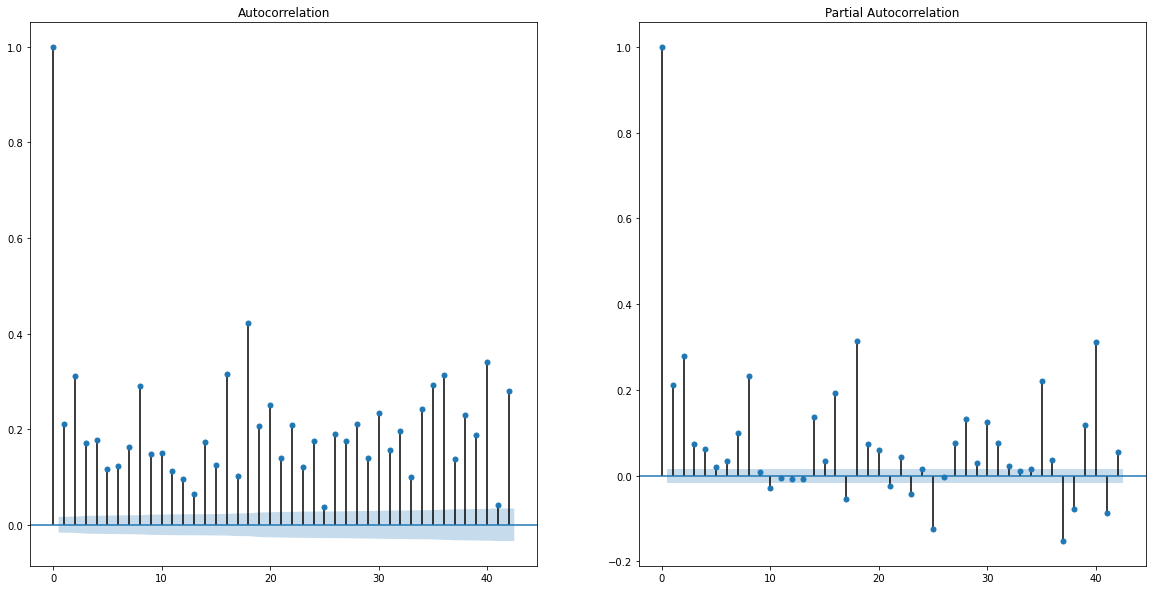

In [ ]:
acf_pacf_viz(ar_metros)

In [ ]:
ar_metros_med = ar_metros.copy()
ar_metros_med = ar_metros.reset_index().groupby(['Date', 'Metro'])['Value'].median().reset_index().set_index('Date')

ar_metros_med.head()

,Metro,Value
Date,,
2010-01-31,Fayetteville-Springdale-Rogers,131318.0
2010-01-31,Hot Springs,122433.5
2010-01-31,Little Rock-North Little Rock-Conway,120405.0
2010-01-31,Searcy,63848.5
2010-02-28,Fayetteville-Springdale-Rogers,130409.0


Looking at the price data from 2010 to 2020 we see that of the four metropolitan areas Fayetteville appears to have the sharpest incline followed by Hot Spring. Little Rock and Searcy appear to be increasing only slightly and are relatively flat comparitively. Therefore, additional search will be limited to these two metros.

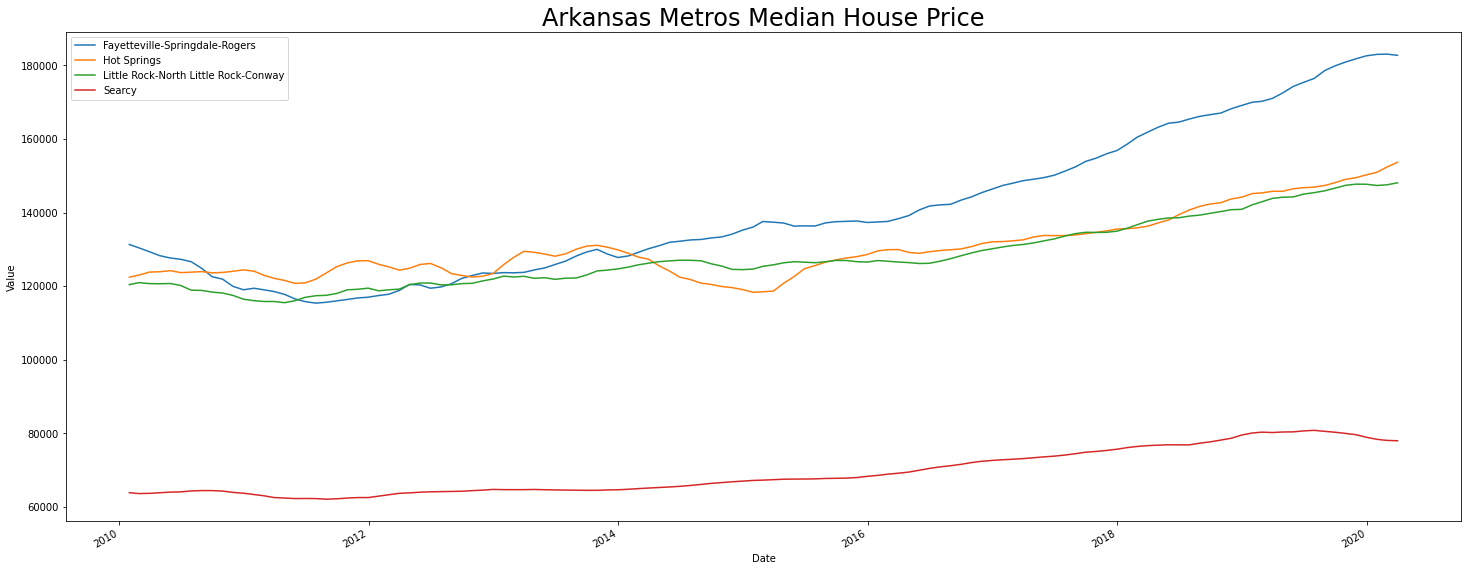

In [ ]:
viz_configs['single_plot'] = True
price_viz(ar_metros_med, 'Metro', 'Arkansas Metros Median House Price')

### Forecasting Fayetteville and Hot Springs

Using Prophet we take the zip codes from Fayetteville and Hot Springs and forecast house prices five years in to the future. [Five years](https://www.nolo.com/legal-encyclopedia/how-should-i-hold-real-estate-investment-property.html) is a typical benchmark for real estate investment.

*Note: All additional forecasts are made with this same assumption*

In [ ]:
ar_forecast = {}

for zip, df in ar_metros.loc[(ar_metros['Metro'] == 'Fayetteville-Springdale-Rogers') | (ar_metros['Metro'] == 'Hot Springs')].groupby('ZipCode'):
  ar_forecast[zip] = housing_forecast(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
zips = [zip for zip in list(ar_forecast.keys())]
ranges = [ar_forecast[x]['range'] for x in list(ar_forecast.keys())]
growth = [ar_forecast[x]['growth'] for x in list(ar_forecast.keys())]
forecast_vals = [ar_forecast[x]['forecast'].iloc[-1]['yhat'] for x in list(ar_forecast.keys())]

ar_housing_dict = {
    'zips': zips,
    'ranges': ranges,
    'growth': growth,
    'forecasts': forecast_vals
}
ar_housing = pd.DataFrame(ar_housing_dict)
ar_housing.sort_values(['growth'], ascending=False)

,zips,ranges,growth,forecasts
36,72768,0.34,0.52,217771.304075
15,72722,0.31,0.37,212490.969981
25,72744,0.24,0.35,188974.860738
23,72739,0.19,0.35,266818.415375
21,72736,0.37,0.34,249094.108660
28,72752,0.59,0.34,131988.753126
38,72774,0.34,0.33,226762.154211
19,72734,0.24,0.32,228689.170315
32,72760,0.47,0.32,97186.548826
14,72721,0.57,0.31,145677.008860


### Recommendations

Considering the below graph, we see that the majority of zip codes within the Fayetteville and Hot Springs metropolitan areas are to the left of the *range* axis. This suggests that the highest and lowest price within those zip codes will be closer to the average price forecasted, and mitigating some of the risk of investing in one of these areas. Alternatively, we can see that many of the zip codes do not have a large forecasted growth. Since the investor wants to make the most amount possible, we take growth in to high consideration. 

Therefore, we will suggest the following zip codes to invest in: 72768, 72722, and 72739. These three zip codes have a larger potential for growth over the next five years relative to the other zip codes and still have a relatively small risk profile.

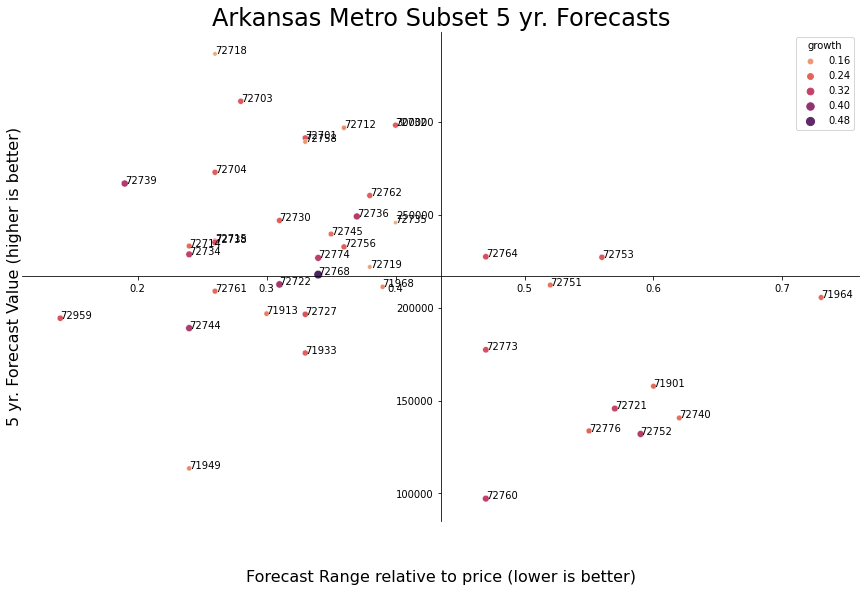

In [ ]:
fig = plt.subplots(figsize=(15, 9))

ax = plt.gca()
sns.scatterplot(x='ranges', y='forecasts', hue='growth', size='growth', palette='flare', data=ar_housing)
for i in range(ar_housing.shape[0]):
 plt.text(x=ar_housing['ranges'][i],y=ar_housing['forecasts'][i],s=ar_housing['zips'][i], 
          fontdict=dict(color='black',size=10))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_xlabel('Forecast Range relative to price (lower is better)', size=16)
ax.yaxis.set_label_coords(0, 0.5)
ax.set_ylabel('5 yr. Forecast Value (higher is better)', size=16)
ax.set_title('Arkansas Metro Subset 5 yr. Forecasts', size=24)

plt.show()

In [ ]:
ar_top3 = [72768, 72722, 72739]

ar_top3_dict = {}

for zip in list(ar_forecast.keys()):
  for x in ar_top3:
    if zip == x:
      ar_top3_dict[zip] = ar_forecast[zip]

Looking over the forecast graphs below, it is recommended that the investor purchase a property mid to late first quarter, as those appear to be the times when houses are at their cheapest. If and when the investor decides to sell, they should consider selling late first quarter to mid second quarter for the highest potential profit.

Additional forecasting is likely to be necessary when selling.

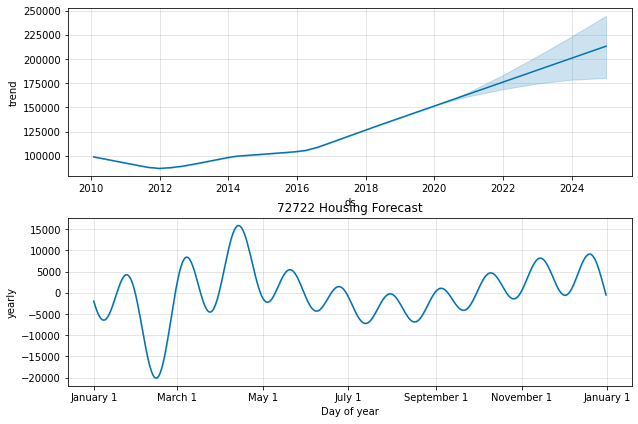

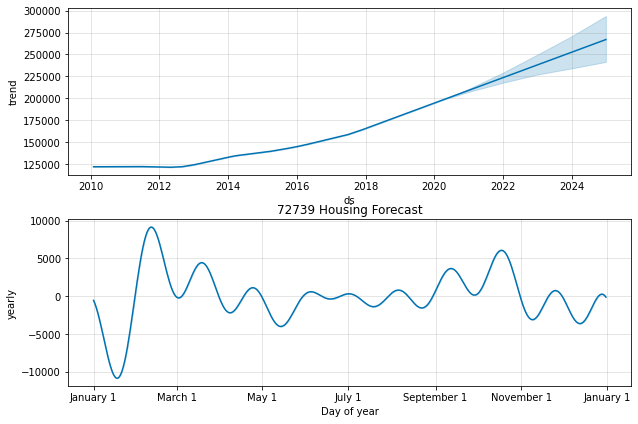

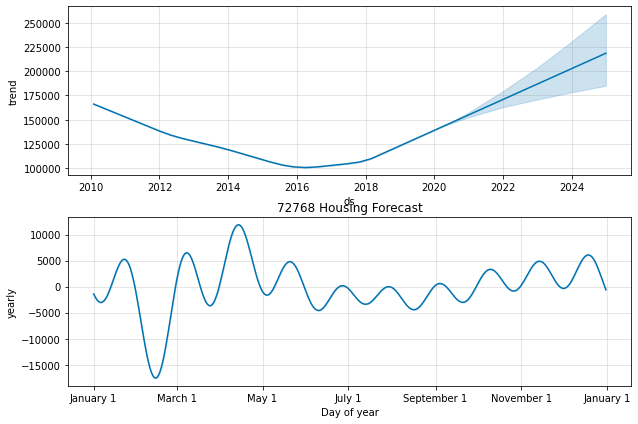

In [ ]:
for zip in list(ar_top3_dict.keys()):
  m = ar_top3_dict[zip]['model']
  forecast = ar_top3_dict[zip]['forecast']

  m.plot_components(forecast)
  plt.title('{} Housing Forecast'.format(zip))

plt.show()

## Beyond Arkansas

**Investor Profile:**
* Investor is interested in high dollar real estate across the US
* Risk profile is considered high. While large profits are preffered, risking the potential of an extremely low price at sell versus the potential of an extremely high sell price is acceptable
* High growth is preferred. However, growth is growth.

In [ ]:
housing_perc_change = housing_data_melt.groupby('ZipCode').apply(get_perc_change).reset_index()
housing_perc_change.rename(columns = {0:'PercChange'}, inplace=True)

### Percent Change Considerations

We first consider the top 25 zip codes with the largest percent growth from 2010 to 2020. The top five all appear to be California based zip codes.

In [ ]:
top_growth = housing_perc_change.nlargest(25, 'PercChange')
top_growth.head()

,ZipCode,PercChange
19125,91108,406.94
19011,90211,346.41
19050,90403,346.01
19924,94610,338.56
19031,90266,332.98


In [ ]:
housing_data_top = pd.merge(housing_data_melt, top_growth, on='ZipCode')
housing_data_top.head()

,ZipCode,State,City,Metro,CountyName,Date,Value,PercChange
0,90026,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2010-01-31,326147.0,216.22
1,90026,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2010-02-28,324908.0,216.22
2,90026,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2010-03-31,323966.0,216.22
3,90026,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2010-04-30,323258.0,216.22
4,90026,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2010-05-31,325506.0,216.22


In [ ]:
top_med = housing_data_top.groupby(['Date', 'ZipCode'])['Value'].median().reset_index().set_index('Date')

top_med.head()

,ZipCode,Value
Date,,
2010-01-31,30310,64629.0
2010-01-31,32208,31666.0
2010-01-31,75208,88169.0
2010-01-31,75226,71204.0
2010-01-31,75246,101316.0


The majority of the top 25 zip codes show relative growth over time. However, it appears that the zip codes near the bottom flatten out significantly.

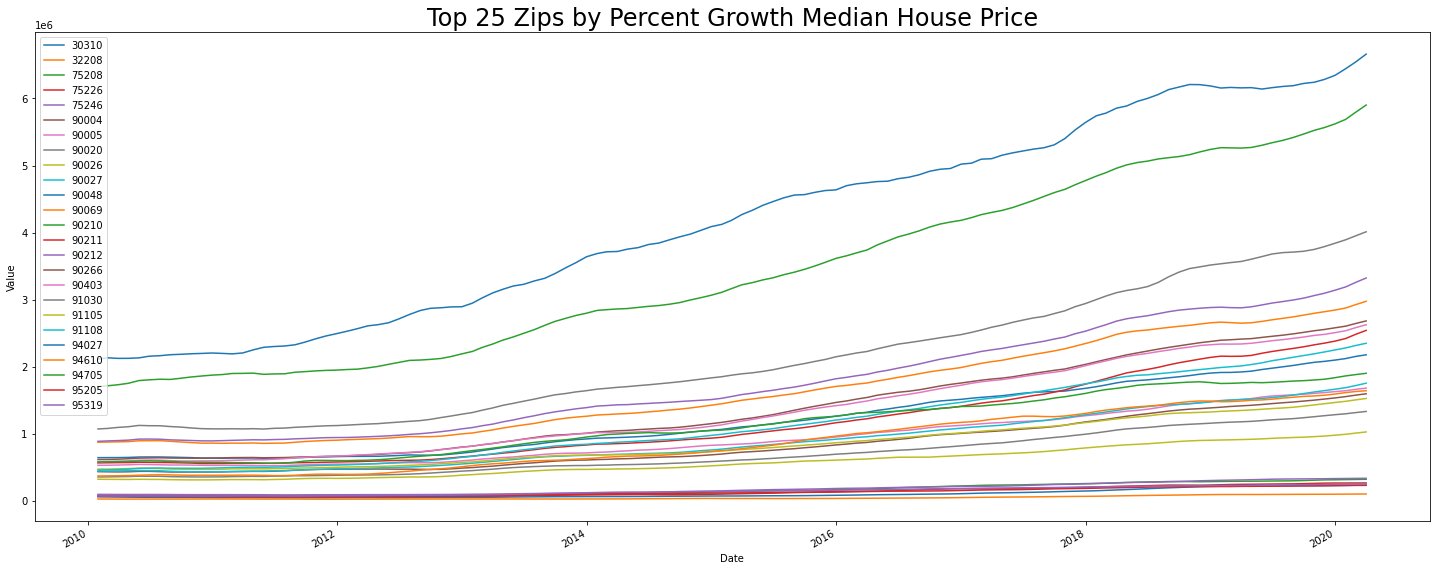

In [ ]:
viz_configs['single_plot'] = True
price_viz(top_med, 'ZipCode', 'Top 25 Zips by Percent Growth Median House Price')

In [ ]:
forecasts = {}

for zip, df in housing_data_top.groupby('ZipCode'):
  forecasts[zip] = housing_forecast(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
zips = [zip for zip in list(forecasts.keys())]
ranges = [forecasts[x]['range'] for x in list(forecasts.keys())]
growth = [forecasts[x]['growth'] for x in list(forecasts.keys())]
forecast_vals = [forecasts[x]['forecast'].iloc[-1]['yhat'] for x in list(forecasts.keys())]

top_housing_dict = {
    'zips': zips,
    'ranges': ranges,
    'growth': growth,
    'forecasts': forecast_vals
}
top_housing = pd.DataFrame(top_housing_dict)
top_housing.head()

,zips,ranges,growth,forecasts
0,30310,0.22,0.83,464115.018967
1,32208,0.25,0.73,191717.880677
2,75208,0.45,0.37,443192.402389
3,75226,0.25,0.54,425331.696358
4,75246,0.36,0.53,532852.385190


### Recommendations

We take a closer look at the top 25 zip codes by forecasting growth over the next five years, and like Arkansas, plot their five year value, relative range, and potential growth.

Looking over the graph below, it appears that the majority of zip codes are located within California and considering the investors profile we would recommend 90020, 90210, and 90212. We omit 94027 due to its relatively small potential for growth compared to the recommended zip codes. The recommended zip codes show a moderate potential for growth as well as relatively high dollars values compared to the other zip codes.

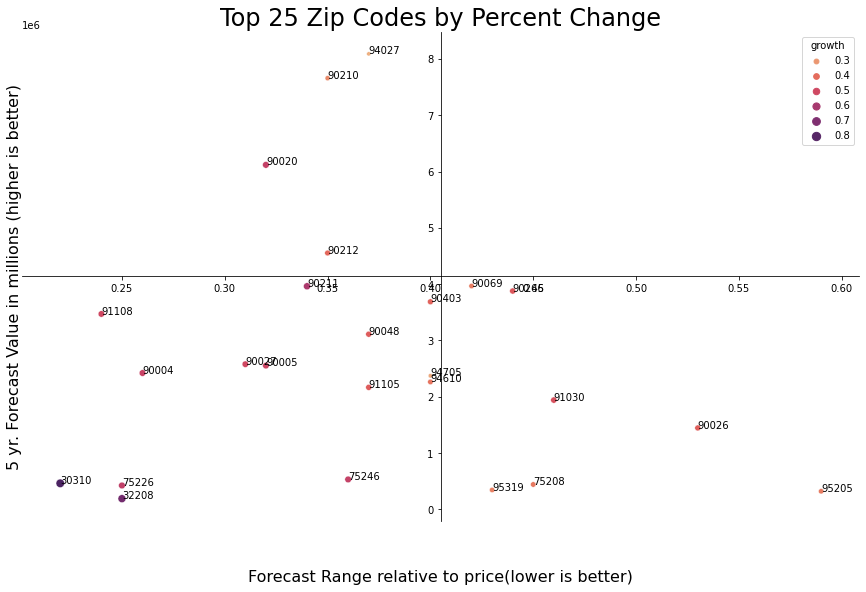

In [ ]:
fig = plt.subplots(figsize=(15, 9))

ax = plt.gca()
sns.scatterplot(x='ranges', y='forecasts', hue='growth', size='growth', palette='flare', data=top_housing)
for i in range(top_housing.shape[0]):
 plt.text(x=top_housing['ranges'][i],y=top_housing['forecasts'][i],s=top_housing['zips'][i], 
          fontdict=dict(color='black',size=10))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_xlabel('Forecast Range relative to price(lower is better)', size=16)
ax.yaxis.set_label_coords(0, 0.5)
ax.set_ylabel('5 yr. Forecast Value in millions (higher is better)', size=16)
ax.set_title('Top 25 Zip Codes by Percent Change', size=24)

plt.show()

In [ ]:
top3 = [94027, 90210, 90020]

top3_dict = {}

for zip in list(forecasts.keys()):
  for x in top3:
    if zip == x:
      top3_dict[zip] = forecasts[zip]

Considering the forecast graphs below, for the 90020 area it is recommended that the investor purchase in either early to mid March or early to mid September as these appear to be the cheapest timeframes. Selling should be considered around mid December.

For both 90210 and 94027, it is recommended to purchase mid February or mid march, while selling early to mid April.

It would also be recommended that another forecast be performed around the time of selling.

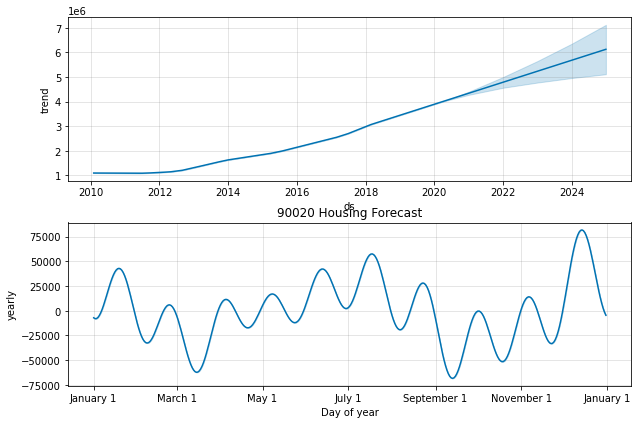

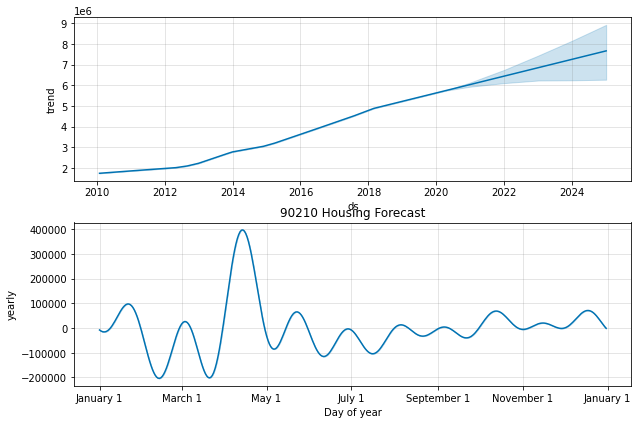

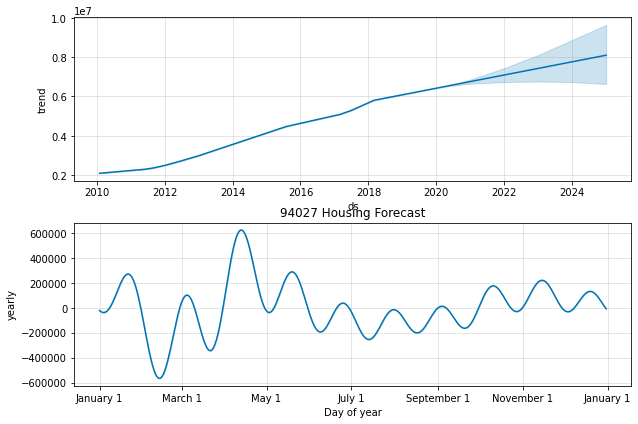

In [ ]:
for zip in list(top3_dict.keys()):
  m = top3_dict[zip]['model']
  forecast = top3_dict[zip]['forecast']

  m.plot_components(forecast)
  plt.title('{} Housing Forecast'.format(zip))

plt.show()

## Population Data

**Investor Profile:**
* Investor is interest in high growth in both dollar value and population
* Believes areas with booming populations will drive up prices beyond forecasted growth
* Moderate risk level. Prefers a small range relative to price

In [ ]:
zipdata_url = "https://www.zipdatamaps.com/national/population/map-of-fastest-growing-zipcodes-in-the-united-states"

res = requests.get(zipdata_url)
page_data = res.text

In [ ]:
soup = bs(page_data, 'lxml')

### Putting it all together

While it has been shown that California has the highest percent growth in dollar value for given data, according to [ZipDataMaps](https://www.zipdatamaps.com/national/population/map-of-fastest-growing-zipcodes-in-the-united-states), only one California zip code is present within the top ten fastest growing zip codes. Therefore, we will be taking in to consideration to top 50 fastest growing zip codes, according to the [ZipDataMaps](https://www.zipdatamaps.com/national/population/map-of-fastest-growing-zipcodes-in-the-united-states) data.

In the below table, we see that of the top five zip codes Texas takes three of the spots. However, we need to combine this with our housing data to get a better idea of if these zip codes are right for our investor.

In [ ]:
table = soup.table

table_headers = []
for i in table.findAll('th')[1:]:
  table_headers.append(re.sub(' ', '', i.text))

zip_data = pd.DataFrame(columns=table_headers)

index = 0 
for tr in table.findAll('tr')[2:]:
  row_data = tr.findAll('td')
  row = [re.sub('\n', '', i.text.strip()) for i in row_data]
  if len(row) < len(table_headers):
    continue
  
  row = row[4:]
  index +=1
  zip_data.loc[index] = row

zip_data.head()

,MapKey/ZIPCode,ZIPCodeName,CountyName,MetroArea/Region,Population(2019),PopulationGrowthRate
1,23511,"Norfolk, VA",City of Norfolk,Tidewater Region,"22,574",818.76%
2,32081,"Ponte Vedra, FL",Saint Johns County,Metro Jacksonville,"19,652",334.39%
3,76177,"Fort Worth, TX",Tarrant County,Metro Dallas-Fort Worth,"20,291",314.86%
4,77441,"Fulshear, TX",Fort Bend County,Metro Houston,"15,974",232.17%
5,75078,"Prosper, TX",Collin County,Metro Dallas-Fort Worth,"31,136",193.96%


In [ ]:
zip_data['PopulationGrowthRate'] = [float(x.strip('%')) for x in zip_data['PopulationGrowthRate']]
zip_data['MapKey/ZIPCode'] = [int(x) for x in zip_data['MapKey/ZIPCode']]
zip_data = zip_data[['MapKey/ZIPCode', 'PopulationGrowthRate']]

In [ ]:
housing_pop = pd.merge(zip_data, housing_perc_change, left_on='MapKey/ZIPCode', right_on='ZipCode' ).drop('MapKey/ZIPCode', axis=1)
housing_pop = pd.merge(housing_data_melt, housing_pop, on='ZipCode')

In [ ]:
housing_pop_med = housing_pop.groupby(['Date', 'ZipCode'])['Value'].median().reset_index().set_index('Date')

housing_pop_med.head()

,ZipCode,Value
Date,,
2010-01-31,20105,543095.0
2010-01-31,20148,513361.0
2010-01-31,20871,440260.0
2010-01-31,31407,148591.0
2010-01-31,32081,327895.0


Not unlike the previous growth chart, and admittedly a probably worse looking chart, a few zip codes show some significant growth, while many appear to show gradual or relatively flat growth over the past ten years.

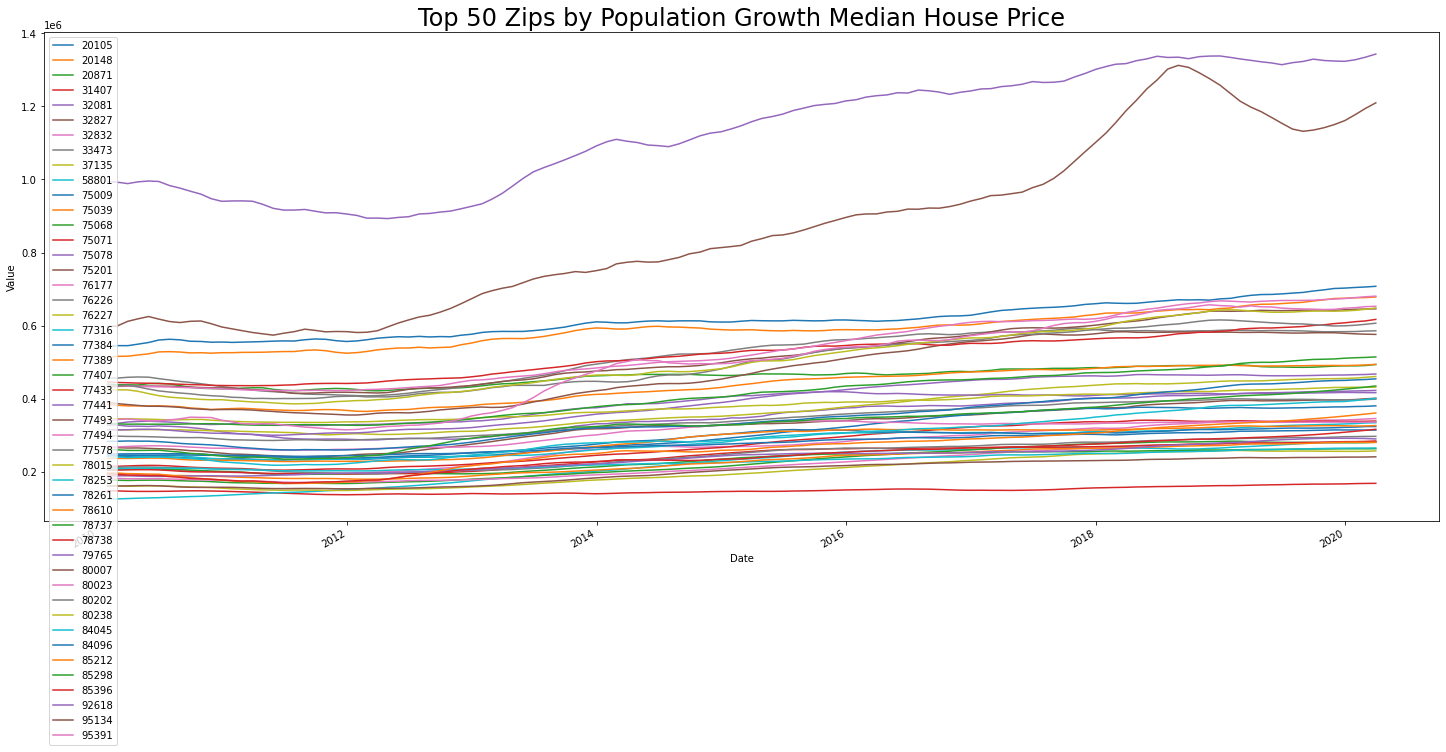

In [ ]:
price_viz(housing_pop_med, 'ZipCode', 'Top 50 Zips by Population Growth Median House Price')

In [ ]:
forecasts_price_pop = {}

for zip, df in housing_pop.groupby('ZipCode'):
  forecasts_price_pop[zip] = housing_forecast(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
zipsdf = housing_pop.groupby('ZipCode').first().reset_index().drop(['Date', 'Value'], axis=1)

Considering the table below, sorted by projected price growth rate then population growth, a California zip code, again, takes the top slot. It also shows a relatively small price range.

As with the others, we will plot the data to get a better outlook.

In [ ]:
zips = [zip for zip in list(forecasts_price_pop.keys())]
ranges = [forecasts_price_pop[x]['range'] for x in list(forecasts_price_pop.keys())]
growth = [forecasts_price_pop[x]['growth'] for x in list(forecasts_price_pop.keys())]
forecast_vals = [forecasts_price_pop[x]['forecast'].iloc[-1]['yhat'] for x in list(forecasts_price_pop.keys())]

top_pop_housing_dict = {
    'zips': zips,
    'growth': growth,
    'ranges': ranges,
    'forecasts': forecast_vals
}
top_pop_housing = pd.DataFrame(top_pop_housing_dict)
top_pop_housing = pd.merge(zipsdf, top_pop_housing, left_on='ZipCode', right_on='zips').drop(['PercChange', 'zips'], axis=1)
top_pop_housing.rename(columns={'growth': 'PriceGrowthRate'}, inplace=True)
top_pop_housing.sort_values(['PriceGrowthRate', 'PopulationGrowthRate'], ascending=False)

,ZipCode,State,City,Metro,CountyName,PopulationGrowthRate,PriceGrowthRate,ranges,forecasts
45,95134,CA,San Jose,San Jose-Sunnyvale-Santa Clara,Santa Clara County,92.98,0.32,0.16,1.646010e+06
41,85212,AZ,Mesa,Phoenix-Mesa-Scottsdale,Maricopa County,73.86,0.29,0.84,4.628596e+05
34,79765,TX,Odessa,Odessa,Ector County,140.32,0.26,0.31,3.738413e+05
42,85298,AZ,Gilbert,Phoenix-Mesa-Scottsdale,Maricopa County,80.92,0.26,0.84,5.441039e+05
40,84096,UT,Herriman,Salt Lake City,Salt Lake County,79.11,0.26,0.44,5.783824e+05
39,84045,UT,Saratoga Springs,Provo-Orem,Utah County,97.59,0.25,0.69,5.035005e+05
43,85396,AZ,Buckeye,Phoenix-Mesa-Scottsdale,Maricopa County,121.65,0.23,0.70,3.846443e+05
32,78737,TX,Austin,Austin-Round Rock,Travis County,72.02,0.20,0.22,6.179954e+05
33,78738,TX,Bee Cave,Austin-Round Rock,Travis County,135.29,0.19,0.35,7.285850e+05
19,77316,TX,Montgomery,Houston-The Woodlands-Sugar Land,Montgomery County,74.49,0.18,0.68,3.939324e+05


### Recommendations

Based on the chart below and the investor profile we recommend the following zip codes for investment: 95134, 80238, 20105. All three zip codes fall within the acceptable risk levels of the profile and provide potential for high dollar gains. Additionally, population growth across all three zip codes appears to be high, and it is assumed that these levels will only increase.

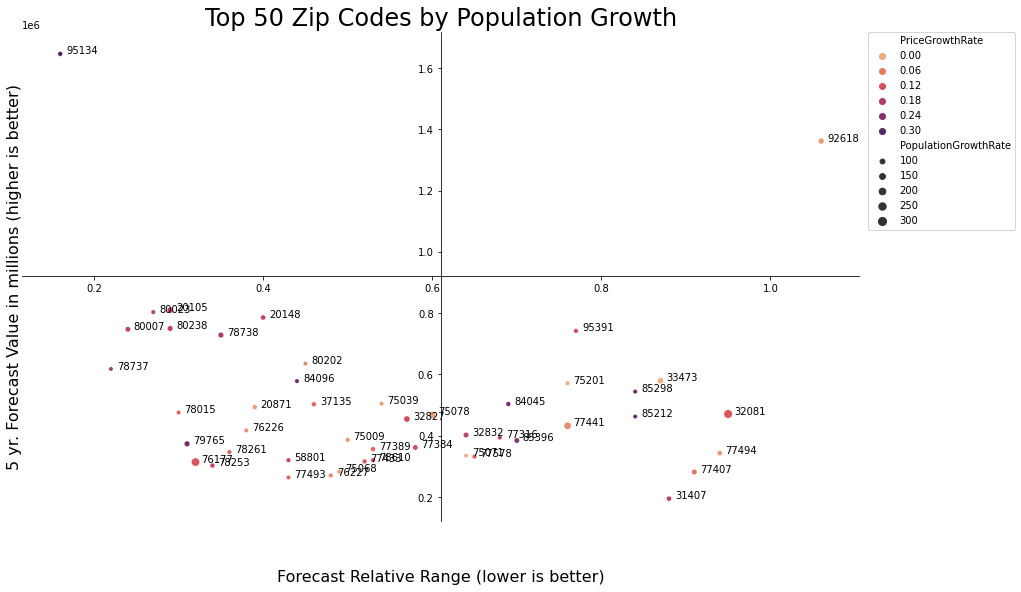

In [ ]:
fig = plt.subplots(figsize=(15, 9))

ax = plt.gca()
sns.scatterplot(x='ranges', y='forecasts', size='PopulationGrowthRate', hue='PriceGrowthRate', palette='flare', data=top_pop_housing)

for i in range(top_pop_housing.shape[0]):
 plt.text(x=top_pop_housing['ranges'][i]+0.007,y=top_pop_housing['forecasts'][i],s=top_pop_housing['ZipCode'][i], 
          fontdict=dict(color='black',size=10)) # ,
          # bbox=dict(facecolor='lightblue',alpha=0.5))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_xlabel('Forecast Relative Range (lower is better)', size=16)
ax.yaxis.set_label_coords(0, 0.5)
ax.set_ylabel('5 yr. Forecast Value in millions (higher is better)', size=16)
ax.set_title('Top 50 Zip Codes by Population Growth', size=24)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
top3 = [95134, 80238, 20105]

In [ ]:
top3_dict = {}

for zip in list(forecasts_price_pop.keys()):
  for x in top3:
    if zip == x:
      top3_dict[zip] = forecasts_price_pop[zip]

Considering the forecast graphs below, for the 20105 area it is recommended that the investor purchase around mid July to early August as these appear to be the cheapest timeframes. There appear to be three potential selling timeframes during mid April, mid to late August, or mid October.

For the 80238 area it is recommended to purchase property between late January to early February or mid December, while selling in either mid February or mid Augst

Finally, for the 95134 area it is recommended to purchase late January to early Februrary or mid April, while selling early to mid mid February.

Like all previous recommendations, it is recommended that another forecast be performed around the time of selling.

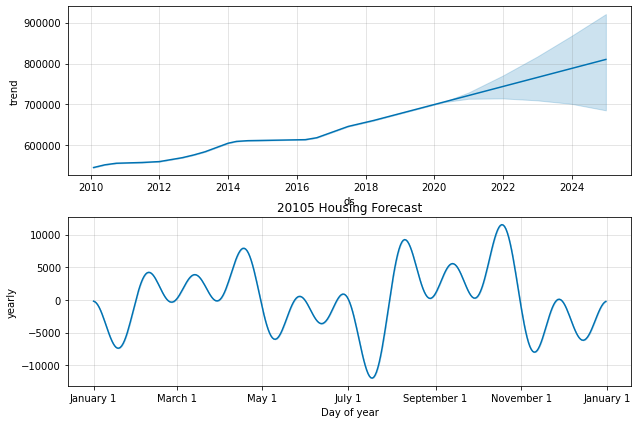

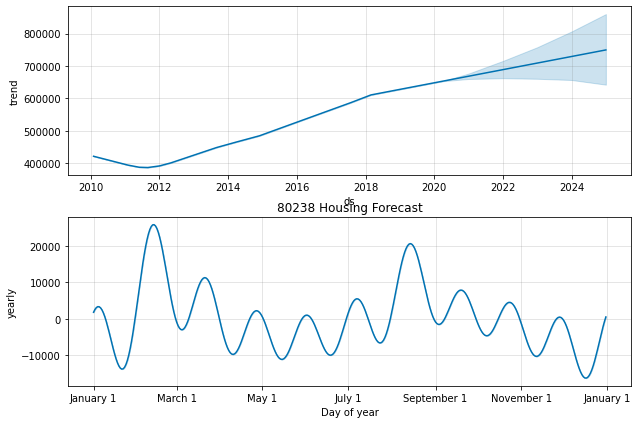

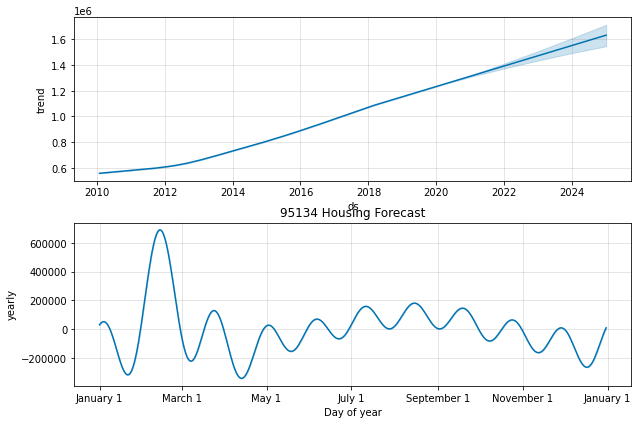

In [ ]:
for zip in list(top3_dict.keys()):
  m = top3_dict[zip]['model']
  forecast = top3_dict[zip]['forecast']

  m.plot_components(forecast)
  plt.title('{} Housing Forecast'.format(zip))

plt.show()